# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

As a data scientist, we need to examine the job postings with salaries and predict the salaries for new postings.

In [55]:
#import your libraries
import pandas as pd
import numpy as np
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


#etc

#your info here
__author__ = "Nikhil Gharge"
__email__ = "nikhilgharge93@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [56]:
#load the data into a Pandas dataframe
def load_dataset():
    trainData_features_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/train_features.csv")
    trainData_target_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/train_salaries.csv")
    testData_features_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/test_features.csv")
    return trainData_features_df, trainData_target_df, testData_features_df

In [57]:
trainData_features_df, trainData_target_df, testData_features_df = load_dataset()

In [58]:
# This file contains features of different employees
trainData_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [59]:
# This file contains the salary of respective employees with their jobId
trainData_target_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [60]:
# We need to predict the salaries for the employees in this test data.
testData_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


### ---- 3 Clean the data ----

In [61]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
def duplicate_data():
    duplicate_train_features = trainData_features_df.duplicated().sum()
    duplicate_train_target=trainData_target_df.duplicated().sum()
    duplicate_test_features=testData_features_df.duplicated().sum()
    return duplicate_test_features, duplicate_train_features,duplicate_train_target

In [62]:
duplicate_test_features, duplicate_train_features,duplicate_train_target = duplicate_data()

In [63]:
print(duplicate_test_features, duplicate_train_features,duplicate_train_target)

0 0 0


As we can see there are no duplicates present in the above three files.

In [64]:
# Create a final dataset by merging trainData_features_df and trainData_target_df
def merge_Datasets():
    salaryPred_Train_data = pd.merge(trainData_features_df,trainData_target_df,how='inner',on='jobId')
    return salaryPred_Train_data

In [65]:
salaryPred_Train_data = merge_Datasets()

In [66]:
salaryPred_Train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [67]:
salaryPred_Train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


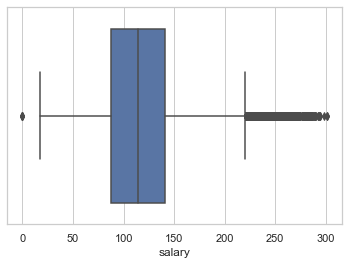

In [68]:
# boxplot for salary columns.
sns.set(style="whitegrid")
ax = sns.boxplot(x=salaryPred_Train_data["salary"])

As it clearly depicts, most of the outliers are in the right most whiskers. 
Finally we will conisder only those values which have salary > 0 in the final dataset

In [69]:
# Boxplot Analysis
info_salaryPredDataset = salaryPred_Train_data.salary.describe()
print(info_salaryPredDataset)
IQR = info_salaryPredDataset['75%'] - info_salaryPredDataset["25%"]
upper = info_salaryPredDataset['75%'] + 1.5 * IQR
lower = info_salaryPredDataset['25%'] - 1.5 * IQR
print("The upper and lower bounds for suspected outliers are {} and {}.".format(upper, lower))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspected outliers are 220.5 and 8.5.


In [70]:
# Considering values related to respective upper and lower bounds
salaryPred_Train_data[salaryPred_Train_data['salary'] < lower]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [71]:
salaryPred_Train_data.loc[salaryPred_Train_data['salary'] > upper, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

In [72]:
# remove salary below 0
salaryPred_Train_data = salaryPred_Train_data[salaryPred_Train_data['salary'] > lower]
salaryPred_Train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  999995 non-null object
companyId              999995 non-null object
jobType                999995 non-null object
degree                 999995 non-null object
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


### ---- 4 Explore the data (EDA) ----

In [73]:

# Correlations between selected features and response
# jobId is discarded because it is unique for individual
def plot_feature(df, col):
    '''
    Make plot for each features
    left, the distribution of samples on the feature
    right, the dependance of salary on the feature
    '''
    plt.figure(figsize = (14, 6))
    plt.subplot(1, 2, 1)
    if df[col].dtype == 'int64':
        df[col].value_counts().sort_index().plot()
    else:
        #change the categorical variable to category type and order their level by the mean salary
        #in each category
        mean = df.groupby(col)['salary'].mean()
        df[col] = df[col].astype('category')
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        df[col].value_counts().plot()
    plt.xticks(rotation=45)
    plt.xlabel(col)
    plt.ylabel('Counts')
    plt.subplot(1, 2, 2)

    if df[col].dtype == 'int64' or col == 'companyId':
        #plot the mean salary for each category and fill between the (mean - std, mean + std)
        mean = df.groupby(col)['salary'].mean()
        std = df.groupby(col)['salary'].std()
        mean.plot()
        plt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, \
                         alpha = 0.1)
    else:
        sns.boxenplot(x = col, y = 'salary', data=df)
    
    plt.xticks(rotation=45)
    plt.ylabel('Salaries')
    plt.show()

In [ ]:
def 

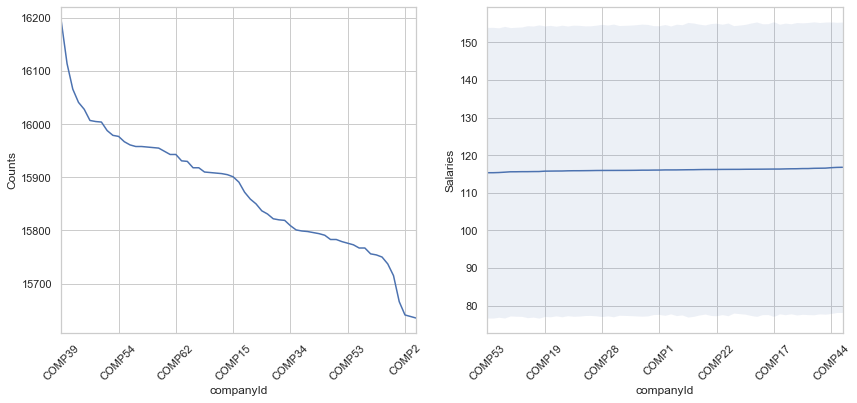

In [74]:
plot_feature(salaryPred_Train_data, 'companyId')

As we can see there isnt any significant relation between target variable salary and companyId

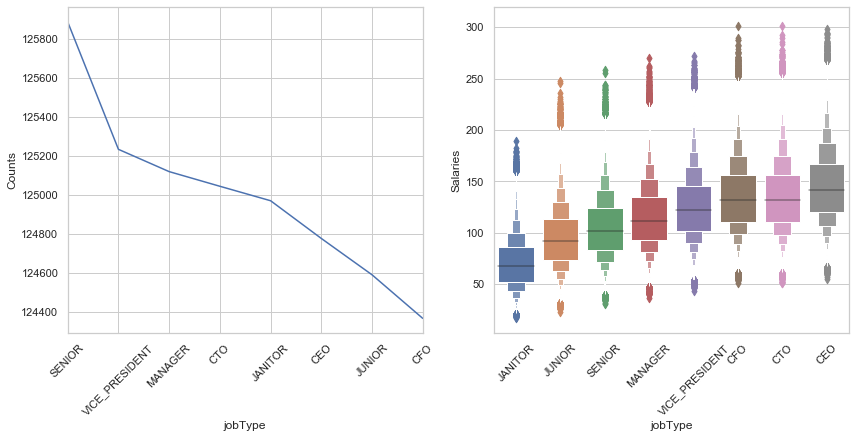

In [75]:
plot_feature(salaryPred_Train_data, 'jobType')

As we can see as position increases salary tends to increase. So there is an positive correlation between salary and jobType.

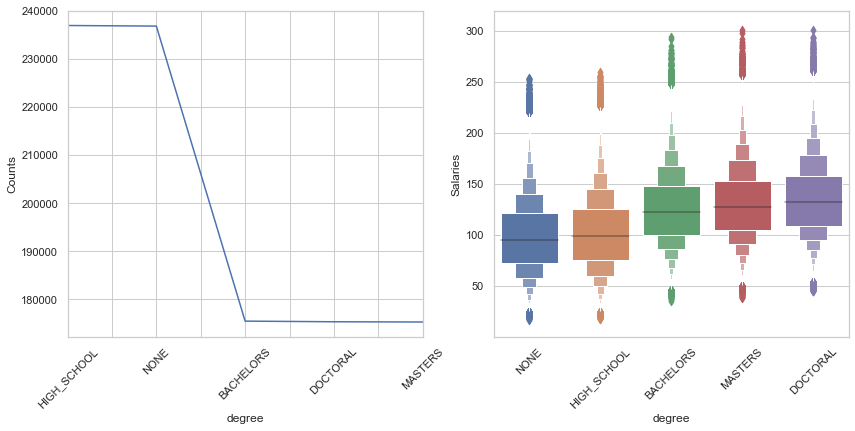

In [76]:
plot_feature(salaryPred_Train_data, 'degree')


As we move up the higher grade, we see a rise in payment of employees. So the target variable salary is positive correlated with degree.

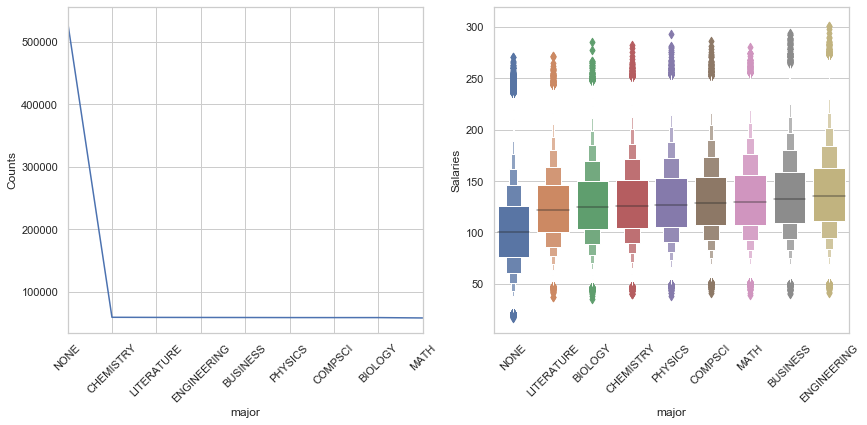

In [77]:
plot_feature(salaryPred_Train_data, "major")

Above pic clearly depicts that most number of salaries are offerred to engineering and business employees.

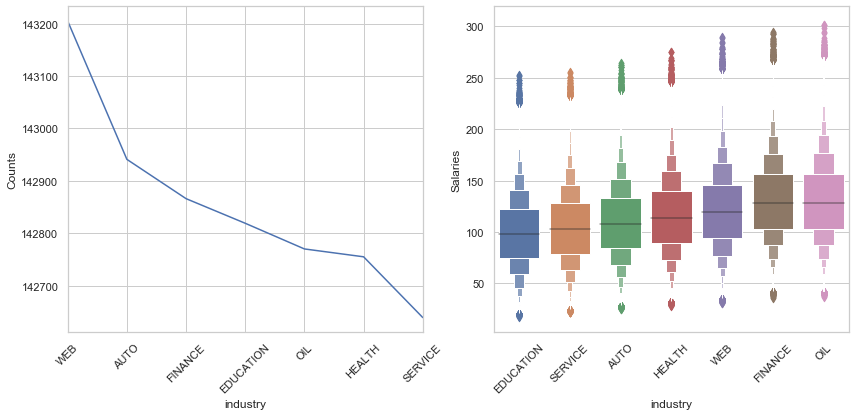

In [78]:
plot_feature(salaryPred_Train_data, "industry")

As we can see that, oil and finance industry employees have almost the same payment. 

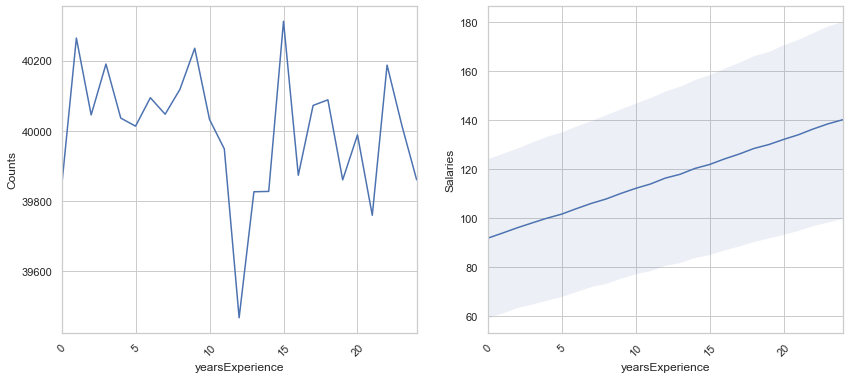

In [79]:
plot_feature(salaryPred_Train_data, 'yearsExperience')

This graph depicts that as yearsOfExperince increases our salaries increases. Basically it depicts an positive correlation between yearsExperience and salary.

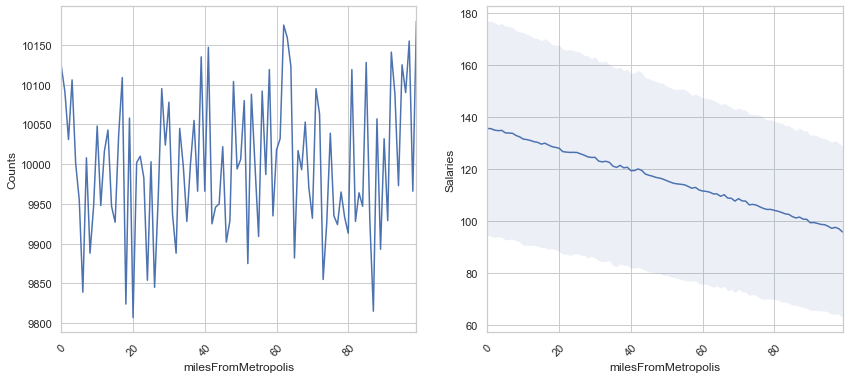

In [80]:
plot_feature(salaryPred_Train_data, 'milesFromMetropolis')

This shows a negative correlation between salary and milesFromMetropolis. As miles tend to increase the salaries get decreased.

In [81]:
def encode_Label(df, col):
    #encode the categories using average salary for each category to replace label
    cat_dict = {}
    cats = salaryPred_Train_data[col].cat.categories.tolist()
    print(cats)
    for cat in cats:
        cat_dict[cat] = salaryPred_Train_data[salaryPred_Train_data[col] == cat]['salary'].mean()
    print(cat_dict)
    df[col] = df[col].map(cat_dict)   

In [82]:
for col in salaryPred_Train_data.columns:
    if salaryPred_Train_data[col].dtype.name == "category":
        print(col)
        encode_Label(salaryPred_Train_data, col)

companyId
['COMP53', 'COMP37', 'COMP57', 'COMP42', 'COMP54', 'COMP18', 'COMP31', 'COMP55', 'COMP45', 'COMP30', 'COMP19', 'COMP35', 'COMP48', 'COMP43', 'COMP15', 'COMP59', 'COMP50', 'COMP7', 'COMP5', 'COMP20', 'COMP28', 'COMP47', 'COMP27', 'COMP26', 'COMP0', 'COMP32', 'COMP8', 'COMP33', 'COMP10', 'COMP46', 'COMP1', 'COMP12', 'COMP39', 'COMP36', 'COMP11', 'COMP56', 'COMP6', 'COMP24', 'COMP3', 'COMP38', 'COMP22', 'COMP52', 'COMP4', 'COMP60', 'COMP25', 'COMP23', 'COMP49', 'COMP62', 'COMP51', 'COMP14', 'COMP17', 'COMP61', 'COMP16', 'COMP29', 'COMP34', 'COMP58', 'COMP9', 'COMP41', 'COMP21', 'COMP13', 'COMP44', 'COMP2', 'COMP40']
{'COMP53': 115.34235547667343, 'COMP37': 115.34504872681546, 'COMP57': 115.39354013431404, 'COMP42': 115.48403688138995, 'COMP54': 115.58978531639231, 'COMP18': 115.59716738735351, 'COMP31': 115.62223914699162, 'COMP55': 115.62370774402233, 'COMP45': 115.64927444794952, 'COMP30': 115.6594351973069, 'COMP19': 115.7565484396541, 'COMP35': 115.77466799056721, 'COMP48': 

In [83]:
salaryPred_Train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,115.345049,135.458547,130.505647,133.322042,115.735540,10,83,130
1,JOB1362684407688,115.756548,145.311425,101.921085,102.583864,121.645362,3,73,101
2,JOB1362684407689,116.224249,125.368630,135.490979,130.372436,115.735540,10,38,137
3,JOB1362684407690,116.199380,115.368518,135.490979,129.072085,109.435222,8,17,142
4,JOB1362684407691,115.888501,125.368630,125.454663,130.372436,130.747659,8,16,163


In [84]:
# Correlation between target variable and feature variable
salaryPred_Train_data.corr()

,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
companyId,1.000000,0.005552,0.004423,0.004490,0.002042,0.001890,-0.002230,0.008498
jobType,0.005552,1.000000,0.288261,0.256843,0.002214,0.001118,0.000024,0.597463
degree,0.004423,0.288261,1.000000,0.853049,0.000870,0.000012,0.001978,0.401300
major,0.004490,0.256843,0.853049,1.000000,0.000367,-0.000129,0.001519,0.378675
industry,0.002042,0.002214,0.000870,0.000367,1.000000,0.000709,-0.001102,0.296626
yearsExperience,0.001890,0.001118,0.000012,-0.000129,0.000709,1.000000,0.000672,0.375013
milesFromMetropolis,-0.002230,0.000024,0.001978,0.001519,-0.001102,0.000672,1.000000,-0.297686
salary,0.008498,0.597463,0.401300,0.378675,0.296626,0.375013,-0.297686,1.000000


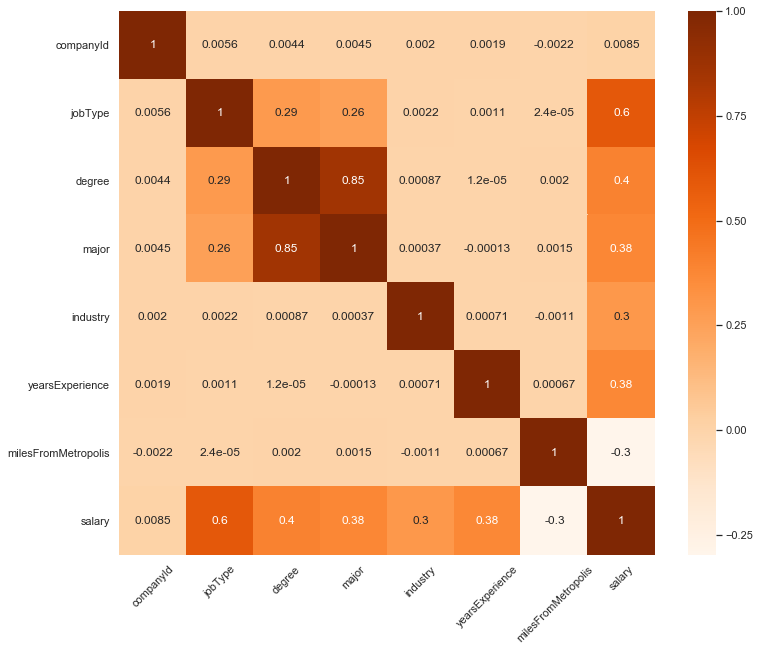

In [90]:
# Graphical Representation of Correlation using HeatMap
fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(salaryPred_Train_data.corr(), cmap = 'Oranges', annot = True)
plt.xticks(rotation=45)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

This correlation HeatMap clearly suggests that salary has a strong relation with jobType followed by major. Also jobType has strong correlation with degree followed by major.

### ---- 5 Establish a baseline ----

In [104]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation


### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [3]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model
#load the data into a Pandas dataframe
def load_dataset():
    trainData_features_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/train_features.csv")
    trainData_target_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/train_salaries.csv")
    testData_features_df = pd.read_csv("/Users/nikhilgharge93gmail.com/Desktop/Data Science Dream Job/Instructions_and_Notebook/salaryPredictionPortfolio/Data/test_features.csv")
    return trainData_features_df, trainData_target_df, testData_features_df    

In [4]:
trainData_features_df, trainData_target_df, testData_features_df = load_dataset()

In [5]:
trainData_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [6]:
trainData_target_df.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [7]:
testData_features_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [8]:
# Create a final dataset by merging trainData_features_df and trainData_target_df
def merge_Datasets():
    salaryPred_Train_data = pd.merge(trainData_features_df,trainData_target_df,how='inner',on='jobId')
    return salaryPred_Train_data

In [9]:
salaryPred_Train_data = merge_Datasets()
salaryPred_Train_data.head()
salaryPred_Train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [10]:
# Check for duplicates and insiginificant data
def clean_data(): 
    sal_Pred_df = salaryPred_Train_data.drop_duplicates(subset="jobId")
    sal_Pred_df = salaryPred_Train_data[salaryPred_Train_data["salary"] > 0]
    return sal_Pred_df

In [11]:
sal_pred_df = clean_data()
sal_pred_df.head()
sal_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  999995 non-null object
companyId              999995 non-null object
jobType                999995 non-null object
degree                 999995 non-null object
major                  999995 non-null object
industry               999995 non-null object
yearsExperience        999995 non-null int64
milesFromMetropolis    999995 non-null int64
salary                 999995 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [12]:
# identifying the categorical and numerical features
sal_pred_cat_features = ["companyId", "jobType", "degree", "major", "industry"]
sal_pred_num_features = ["yearsExperience", "milesFromMetropolis"]
sal_pred_target = "salary"

In [13]:
# onehotencoding is performed
def encode_features(salPredDF, cat_feat=None, num_feat=None):
    cat_features = pd.get_dummies(salPredDF[cat_feat])
    num_features = salPredDF[num_feat].apply(pd.to_numeric)
    return pd.concat([cat_features,num_features], axis = 1)

In [14]:
sal_pred_features_df = encode_features(sal_pred_df, cat_feat=sal_pred_cat_features, num_feat=sal_pred_num_features)
sal_pred_features_df.head()

,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,...,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,10,83
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3,73
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,10,38
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,8,17
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,8,16


In [15]:
sal_pred_test_df = encode_features(testData_features_df, cat_feat=sal_pred_cat_features, num_feat=sal_pred_num_features)
sal_pred_test_df.head()

,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,...,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,22,73
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,20,47
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,17,9
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,14,96
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,10,44


In [16]:
# Add the target column to the final dataset
def target_dataset():
    # get target_df for further computation
    return sal_pred_df['salary']

In [17]:
sal_pred_target_df = target_dataset()
sal_pred_target_df.head()

0    130
1    101
2    137
3    142
4    163
Name: salary, dtype: int64

### ---- 8 Create models ----

In [18]:
#create and tune the models that you brainstormed during part 2
models = []
mean_mse = {}
cv_std = {}
logistic_Reg = LinearRegression()
logistic_Reg_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
random_forest = RandomForestRegressor(n_estimators=60, n_jobs=-1, max_depth=10, min_samples_split=8, \
                               max_features=30, verbose=5)
grad_Boost_Reg = GradientBoostingRegressor(n_estimators=40, max_depth=5, loss='ls', verbose=5)

# Appending each models
models = [logistic_Reg, logistic_Reg_std_pca, random_forest, grad_Boost_Reg]

### ---- 9 Test models ----

In [19]:
#do 5-fold cross validation on models and measure MSE
def train_model(model, feature_df, target_df, mean_mse, cv_std):
    MSE = -1.00*cross_val_score(model, feature_df, target_df, cv=5, n_jobs=-1,scoring='neg_mean_squared_error')
    mean_mse[model] = np.mean(MSE)
    cv_std[model] = np.std(MSE)

In [22]:
for i in range(len(models)):
    train_model(models[i], sal_pred_features_df.head(100000), sal_pred_target_df.head(100000), mean_mse, cv_std)
                   

In [23]:
for model in models:
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])


Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Average MSE:
 386.1256044850716
Standard deviation during CV:
 0.7269822974060407

Model:
 Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])
Average MSE:
 386.117971937751
Standard deviation during CV:
 0.7339150752853658

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=30, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=8, min_weight_fraction_leaf=0.0,
           n_estimators=60, n_jobs=-1, oob_score=False, random_state=None,
           verbose=5, warm_s

### ---- 10 Select best model  ----

In [24]:
#select the model with the lowest error as your "production" model
model = min(mean_mse, key=mean_mse.get)
print("Model with lowest MSE")
print(model)

Model with lowest MSE
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])


## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [25]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

# Fitting the model to trainset
model.fit(sal_pred_features_df, sal_pred_target_df)

# Create predictions on test data
sal_predictions = model.predict(testData_features_df)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)


ValueError: could not convert string to float: 'JOB1362685407687'

### Hyperparameter Tunning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 60, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [15, 30, 45]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(25, 100, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [40, 60, 80]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
rf_random = RandomizedSearchCV(estimator = random_forest, param_distributions = random_grid, n_iter = 3, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(sal_pred_features_df, sal_pred_target_df)
rf_random.best_params_

### ---- 12 Deploy solution ----

In [16]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data